# S3W10D2: 梯度消失与激活函数 (Gradient Vanishing & Activations)

## 1. 理论：为什么是 0.25？

请在 Notebook 的 Markdown 单元格中记录以下核心推导。这是面试必考题。

### Sigmoid 的致命弱点

Sigmoid 函数公式：
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

它的导数公式（我们昨天用到了）：
$$\sigma'(x) = \sigma(x) (1 - \sigma(x))$$

**极值分析**：

* 当  $x=0$  时，$\sigma(0) = 0.5$。
* 代入导数公式：$\sigma'(0) = 0.5 \times (1 - 0.5) = \mathbf{0.25}$。
* 这是导数的**最大值**。也就是说，无论  是多少，梯度经过 Sigmoid 层后，至少会缩小为原来的 1/4。

### 链式法则的连乘效应

假设我们有一个 10 层的网络，每一层都用 Sigmoid。根据链式法则，梯度从第 10 层传回第 1 层，大约需要乘以 10 次导数：

$$\text{Grad}_{layer1} \approx \text{Grad}_{loss} \times 0.25 \times 0.25 \times ... \times 0.25$$

$$0.25^{10} \approx 0.00000095$$

**结论**：底层的权重几乎收不到任何更新信号，网络前几层处于“瘫痪”状态。这就是为什么 2010 年之前深层网络很难训练。

## 2. 实验：亲眼看到梯度消失

我们要用 PyTorch 构建一个 20 层的全连接网络，分别用 Sigmoid 和 ReLU，看看梯度的分布情况。

请将以下代码复制到 Notebook 中运行：

--- Analyzing Sigmoid ---


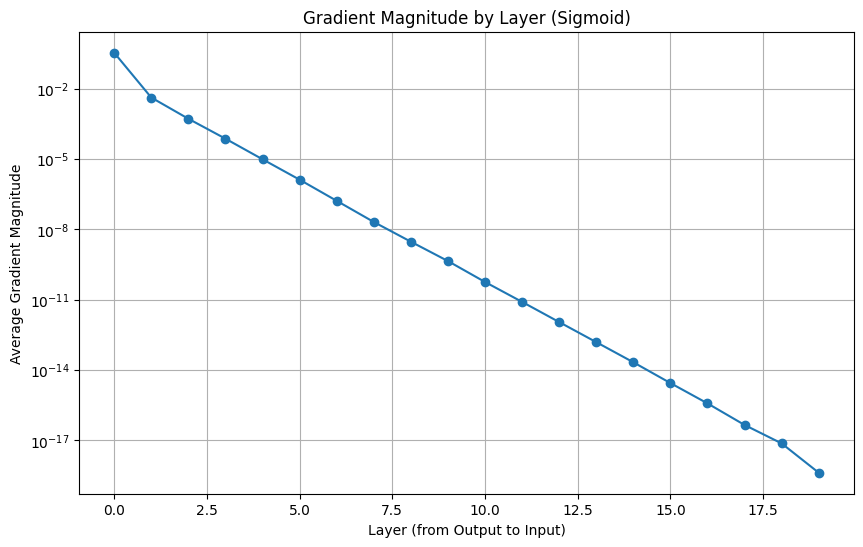

最后一层（输出）梯度：0.345913
第一层（输入）梯度：0.0000000000
比值（第一层/最后一层）：1.1693168625094153e-18


--- Analyzing ReLU ---


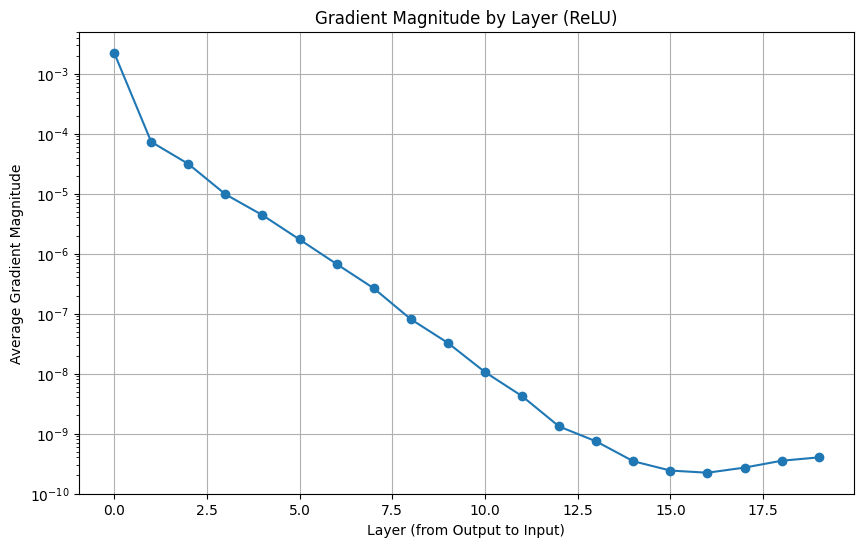

最后一层（输出）梯度：0.002235
第一层（输入）梯度：0.0000000004
比值（第一层/最后一层）：1.7911313680877015e-07




In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 设置随机种子，保证结果可复现
torch.manual_seed(42)

def visualize_gradients(activation_name, activation_func):
    """
    构建一个 20 层的全连接网络，并可视化每一层梯度的均值
    """
    # 1. 构建 20 层的深层网络
    layers = []
    num_layers = 20
    input_dim = 100
    hidden_dim = 100
    
    # 输入层 -> 隐藏层 ... -> 输出层
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(activation_func)
    
    for _ in range(num_layers - 2):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(activation_func)
        
    layers.append(nn.Linear(hidden_dim, 1)) # 输出层
    
    model = nn.Sequential(*layers)
    
    # 2. Forward Pass
    x = torch.randn(128, input_dim) # Batch size 128
    y = torch.randn(128, 1)         # Dummy target
    
    output = model(x)
    loss = (output - y).pow(2).mean()
    
    # 3. Backward Pass
    model.zero_grad()
    loss.backward()
    
    # 4. 收集梯度
    grads = []
    layer_names = []
    
    # 倒序遍历（从输出层到输入层），模拟反向传播方向
    print(f"--- Analyzing {activation_name} ---")
    
    # 这里的 logic 是筛选出 Linear 层
    linear_layers = [m for m in model if isinstance(m, nn.Linear)]
    # 我们反着看：从第 20 层 -> 第 1 层
    for i, layer in enumerate(reversed(linear_layers)):
        grad_mean = layer.weight.grad.abs().mean().item()
        grads.append(grad_mean)
        layer_names.append(f"L{num_layers - i}")
        
    # 5. 绘图
    plt.figure(figsize=(10, 6))
    plt.plot(grads, marker='o')
    plt.title(f'Gradient Magnitude by Layer ({activation_name})')
    plt.xlabel('Layer (from Output to Input)')
    plt.ylabel('Average Gradient Magnitude')
    plt.yscale('log') # 使用对数坐标，因为数值差异巨大
    plt.grid(True)
    plt.show()
    
    print(f"最后一层（输出）梯度：{grads[0]:.6f}")
    print(f"第一层（输入）梯度：{grads[-1]:.10f}")  # 注意精度
    print(f"比值（第一层/最后一层）：{grads[-1]/grads[0]}")
    print("\n")
# --- 实验 1: Sigmoid ---
visualize_gradients("Sigmoid", nn.Sigmoid())

# --- 实验 2: ReLU ---
visualize_gradients("ReLU", nn.ReLU())

### 观察重点 (What to watch):

1. **Sigmoid 图**: 线的走势应该是**断崖式下跌**。看 Output 层的梯度可能还有 0.01，到了 Input 层（L1）可能就变成 `1e-9` 甚至 `0` 了。
2. **ReLU 图**: 线的走势应该比较**平稳**，或者至少在一个数量级内震荡。因为 ReLU 在  时导数为 1， ，梯度可以无损地传回去。



## 3. 今日算法 (LeetCode 226)

**题目**: [226. Invert Binary Tree (翻转二叉树)](https://leetcode.com/problems/invert-binary-tree/)
**背景**: 这是一个著名的梗。Homebrew（Mac 上的包管理工具）的作者 Max Howell 去 Google 面试，虽然他写的软件 Google 90% 的工程师都在用，但他因为写不出“翻转二叉树”被拒了。

**逻辑**:

* 对于根节点，交换它的左孩子和右孩子。
* 然后递归地去翻转左子树。
* 递归地去翻转右子树。

In [ ]:
# Definition for a binary tree node.

from typing import Optional
class TreeNode:
    def __init__(self, val=0, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right
class Solution:
    def invertTree(self, root: Optional[TreeNode]) -> Optional[TreeNode]:
        # 1. 终止条件
        if not root:
            return None
        
        # 2. 交换左右 (Action)
        # Python 的平行赋值让交换变得很简单
        root.left, root.right = root.right, root.left
        
        # 3. 递归下探
        self.invertTree(root.left)
        self.invertTree(root.right)
        
        return root



**另一种更骚的写法 (利用返回值)**：

```python
class Solution:
    def invertTree(self, root: Optional[TreeNode]) -> Optional[TreeNode]:
        if not root:
            return None
        # 当前节点的左 = 翻转后的右
        # 当前节点的右 = 翻转后的左
        root.left, root.right = self.invertTree(root.right), self.invertTree(root.left)
        return root

```

---

## 4. 今日总结 (Checkout)

运行完代码后，你应该能得出以下结论，并在面试中自信地回答：

* **Q: 为什么现在深层网络（ResNet, BERT）都不用 Sigmoid 做激活函数了？**
* **A**: 因为 Sigmoid 的导数最大只有 0.25，在深层网络中会导致严重的梯度消失问题，使得底层参数无法有效更新。


* **Q: ReLU 解决了什么？有什么副作用？**
* **A**: ReLU 在正半轴导数为 1，解决了梯度消失。副作用是负半轴导数为 0，可能导致“神经元死亡”（Dead ReLU），即某个神经元永远不激活，梯度永远为 0。
* *(进阶补充: Leaky ReLU 或 GeLU 可以缓解 Dead ReLU 问题)*。



**Action**:

1. 运行实验，截图保存那两张梯度的图表。
2. AC LeetCode 226。
3. 提交 Git。

```bash
git add stage3/week10/
git commit -m "feat(stage3): visualize gradient vanishing sigmoid vs relu"
git push

```

准备好后，告诉我实验结果！Sigmoid 的第一层梯度是不是小得看不见了？